<a href="https://colab.research.google.com/github/KhotNoorin/Deep-Learning/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer (ViT):


Unlike traditional convolutional neural networks (CNNs), which rely on local receptive fields and convolutional filters, Vision Transformers treat an image as a **sequence of fixed-size patches**, enabling **global context modeling** from the very first layer using **self-attention mechanisms**.

---

## Core Idea

The fundamental idea behind ViT is to model images in the same way that transformers model text:
- In NLP, a sentence is tokenized into words or subwords, and each token is embedded into a vector space.
- In ViT, an image is divided into **non-overlapping square patches**, each of which is **flattened** and **projected** into a learnable embedding vector.

These embeddings are treated as tokens in a sequence, and then processed by a **standard transformer encoder**, enabling the model to capture long-range dependencies between all parts of the image.

---

## Architecture Overview

### 1. **Patch Embedding**
- Given an image of size **H × W × C**, it is divided into **N patches** of size **P × P**.
- Each patch is flattened to a 1D vector and mapped to a **D-dimensional** embedding using a linear projection.

### 2. **Positional Embedding**
- Since transformers are permutation-invariant, **positional encodings** are added to retain spatial information.
- These are learnable vectors added to each patch embedding.

### 3. **CLS Token**
- A special learnable **classification token** CLS is prepended to the sequence of patch embeddings.
- The final representation of this token is used for image-level prediction (e.g., classification).

### 4. **Transformer Encoder**
- A standard **transformer encoder** processes the sequence, consisting of:
  - Multi-Head Self-Attention (MHSA)
  - Feed-Forward Network (MLP)
  - Layer Normalization
  - Residual Connections

### 5. **Classification Head**
- The output corresponding to the CLS token is passed through an MLP head to produce class scores.

---

## Advantages of ViT over CNNs

| Aspect                | CNN                         | Vision Transformer (ViT)              |
|-----------------------|------------------------------|----------------------------------------|
| Inductive Bias        | Strong (locality, translation invariance) | Weak (learned from data)         |
| Receptive Field       | Grows with depth             | Global from the first layer            |
| Data Requirements     | Generalizes well on small data | Needs large datasets (e.g., JFT-300M) |
| Interpretability      | Hard to visualize attention  | Attention maps are inherently explainable |

---

## Challenges and Limitations

- **Data Efficiency**: ViTs require large-scale datasets for training from scratch.
- **Computational Cost**: Transformers scale quadratically with sequence length, making them expensive for high-resolution images.
- **Lack of Local Biases**: Unlike CNNs, ViTs do not encode locality or hierarchical features by default, which can be a disadvantage on smaller datasets.

---

## Improvements and Variants

To overcome these challenges, many improvements have been proposed:

- **DeiT (Data-efficient Image Transformer)**: Introduces knowledge distillation to train ViTs on smaller datasets.
- **Swin Transformer**: Adds hierarchical structure and shifted windows to reduce computation.
- **CvT, PVT, T2T-ViT**: Incorporate convolutional layers or pyramid structures to improve performance and efficiency.

---

## Applications

- Image Classification
- Object Detection
- Semantic Segmentation
- Video Understanding
- Medical Imaging
- Remote Sensing


---

## Summary

The Vision Transformer represents a paradigm shift in computer vision by removing convolutional inductive biases and modeling image patches as sequences using transformer-based architectures. While ViTs are powerful and highly scalable, they are most effective when trained on large datasets, and often require hybrid techniques or architectural enhancements to match CNN performance on smaller tasks.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

#  Hyperparameters

In [8]:
input_shape = (32, 32, 3)
patch_size = 4
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [128, 64]
transformer_layers = 8
mlp_head_units = [128, 64]
num_classes = 10

#  Load CIFAR-10 Data


In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


#  Patch Creation Layer


In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#  Patch Encoder Layer


In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

#  ViT Model


In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(transformer_units[0], activation="gelu")(x3)
        x3 = layers.Dense(transformer_units[1], activation="gelu")(x3)
        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Classification head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation="gelu")(representation)
        representation = layers.Dropout(0.5)(representation)
    logits = layers.Dense(num_classes)(representation)

    return keras.Model(inputs=inputs, outputs=logits)

#  Compile & Train

In [14]:
vit_classifier = create_vit_classifier()
vit_classifier.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [15]:
vit_classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 48)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 64, 64)    │      7,232 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64, 64)    │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ dense_2[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 64)    │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,206,282 (4.60 MB)

 Trainable params: 1,206,282 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

#  Training

In [16]:
vit_classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 48ms/step - accuracy: 0.0983 - loss: 2.3881 - val_accuracy: 0.1058 - val_loss: 2.3025
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.0991 - loss: 2.3029 - val_accuracy: 0.0958 - val_loss: 2.3031
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.0980 - loss: 2.3029 - val_accuracy: 0.0950 - val_loss: 2.3031
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.1000 - loss: 2.3029 - val_accuracy: 0.0976 - val_loss: 2.3027
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.0971 - loss: 2.3030 - val_accuracy: 0.0976 - val_loss: 2.3030
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.1038 - loss: 2.3038 - val_accuracy: 0.1038 - val_loss: 2.3026
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.0978 - loss: 2.3029 - val_accuracy: 0.1024 - val_loss: 2.3026
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.0984 - loss: 2.3030 - 

#  Evaluation

In [17]:
test_loss, test_acc = vit_classifier.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1001 - loss: 2.3028


In [18]:
print(f"\nTest accuracy: {test_acc:.4f}")


Test accuracy: 0.1000


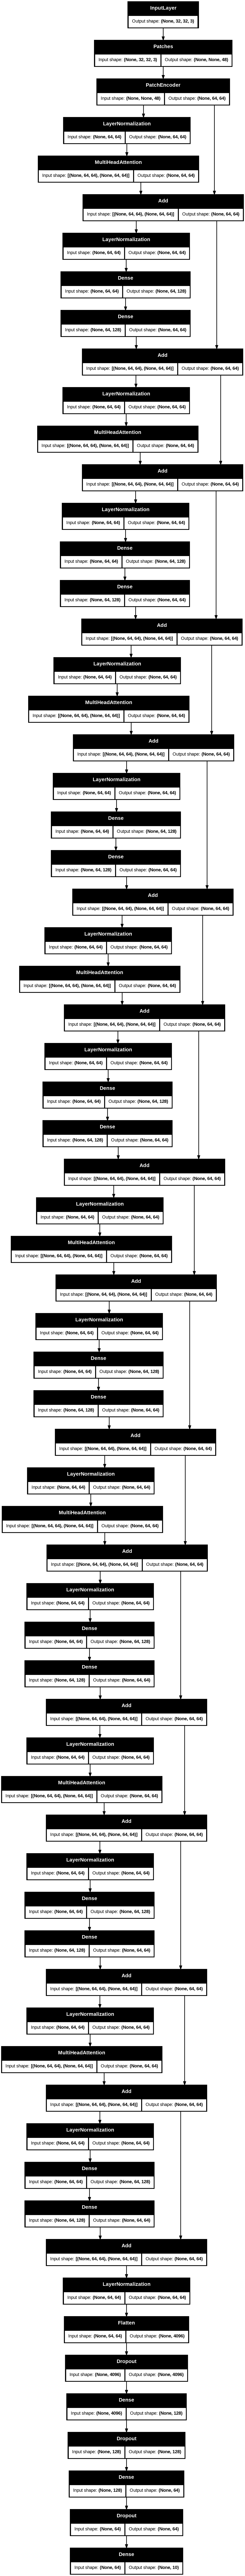

In [19]:
keras.utils.plot_model(vit_classifier, show_shapes=True, to_file='vit_model.png')

In [20]:
import matplotlib.pyplot as plt

history = vit_classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.0978 - loss: 2.3029 - val_accuracy: 0.0976 - val_loss: 2.3030
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1016 - loss: 2.3028 - val_accuracy: 0.0958 - val_loss: 2.3027
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1000 - loss: 2.3027 - val_accuracy: 0.0986 - val_loss: 2.3032
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1000 - loss: 2.3029 - val_accuracy: 0.0970 - val_loss: 2.3026
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.0972 - loss: 2.3031 - val_accuracy: 0.0976 - val_loss: 2.3033
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1005 - loss: 2.3029 - val_accuracy: 0.0976 - val_loss: 2.3029
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.0991 - loss: 2.3029 - val_accuracy: 0.1024 - val_loss: 2.3026
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1015 - loss: 2.3029 - 

In [21]:
# Plot training curves
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

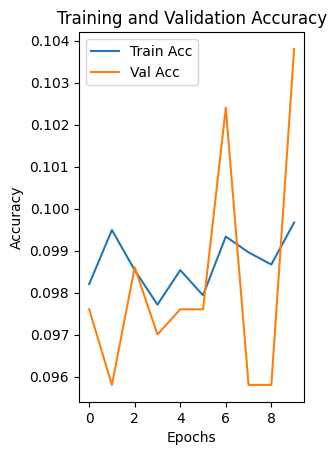

In [22]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

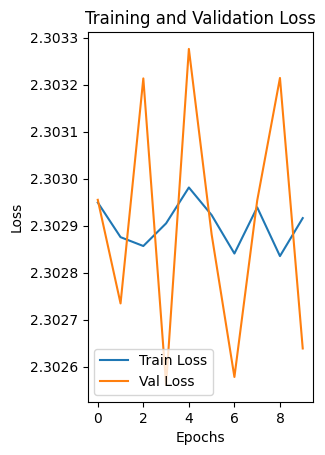

In [23]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()